### Synaptic Impact and Synaptic Reserve

synaptic reserve is the area between PSC decay curve and its steady state value during a long train of stimulus pulses.

![notes_figures\Galarreta-Hestrin_1998_Fig6.png](notes_figures\Galarreta-Hestrin_1998_Fig6.png)

Synaptic Impact:
Product of PSC amplitude and Presynaptic stimulation frequency. (Galarreta-Hestrin_1998) --> This estimates synaptic impulses per second. (my understanding)  
I think it is better represented by the product of area under the PSCs and the presynaptic stimulation frequency. --> This estimates synaptic charge delivery rate.

![notes_figures\Galarreta-Hestrin_1998_Fig6.png](notes_figures\Galarreta-Hestrin_1998_Fig7.png)

In [1]:
import sys
import os
import importlib
from   pathlib      import Path
import pickle
import psutil

import numpy                as np
import matplotlib           as mpl
import matplotlib.pyplot    as plt
import seaborn              as sns
import pandas               as pd

from scipy.signal   import find_peaks, peak_widths
# from scipy.signal   import butter, bessel, decimate, sosfiltfilt
# from scipy.stats    import kruskal, wilcoxon, mannwhitneyu, ranksums
# from scipy.signal   import filter_design
# from scipy.optimize import curve_fit

# from PIL            import Image

from eidynamics     import utils, data_quality_checks, ephys_classes, plot_tools, expt_to_dataframe
# from eidynamics     import pattern_index
# from eidynamics     import abf_to_data
# from eidynamics     import fit_PSC
# from Findsim        import tab_presyn_patterns_LR_43
# import parse_data
# import all_cells
# import plotFig2
# from stat_annotate import *

%matplotlib widget
%tb
# import plotly.express as px
# import plotly.graph_objects as go
# sns.set_context('paper')

# make a colour map viridis
viridis = mpl.colormaps["viridis"]
flare   = mpl.colormaps["flare"]
crest   = mpl.colormaps["crest"]
magma   = mpl.colormaps["magma"]
edge    = mpl.colormaps['edge']

color_E = "flare"
color_I = "crest"
color_freq = {1:magma(0.05), 5:magma(0.1), 10:magma(0.2), 20:magma(.4), 30:magma(.5), 40:magma(.6), 50:magma(.7), 100:magma(.9)}
color_squares = color_squares = {1:viridis(0.2), 5:viridis(.4), 7:viridis(.6), 15:viridis(.8), 20:viridis(1.0)}
color_EI = {-70:flare(0), 0:crest(0)}

Fs = 2e4

freq_sweep_pulses = np.arange(9)

No traceback available to show.


In [2]:
sns.set_context(context='paper', font_scale=2.5, )
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
figure_raw_material_location = Path(r"paper_figure_matter\\")
paper_figure_export_location = Path(r"paper_figures\\Figures_from_Lit\\")
data_path                    = Path(r"parsed_data\\")
cell_data_path               = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Data\Screened_cells\\")

In [4]:
# import VC data
# Full data set for FreqSweep protocol (df) (raw dataframe with metadata)
freq_sweep_vc_datapath =  Path("all_cells_FreqSweep_VC_long.h5" )
LTMRand_vc_datapath =  Path("all_cells_LTMRand_VC_long.h5" )
spiketrain_vc_datapath =  Path("all_cells_SpikeTrain_VC_long.h5" )

### for freq sweep and LTM rand data
# df1 = pd.read_hdf(freq_sweep_vc_datapath, key='data')
# print(f"Full FreqSweep Dataframe has {df1.shape} ")
# df2 = pd.read_hdf(LTMRand_vc_datapath, key='data')
# print(f"Full FreqSweep Dataframe has {df2.shape}")
# join the two if the shape[1] is same
# df = pd.concat([df1, df2], axis=0)
# # df.loc[:, 'SpikingFlag'] = (df.iloc[:, 4049:20049].max(axis=1) > 20).astype(int)
# del df1, df2

df = pd.read_hdf(data_path / spiketrain_vc_datapath, key='data')
dfslice = df[
            (df['location'] == 'CA1') &
            (df['condition'] == 'Control') &
            (df['ac_noise_power_in_ch0'] < 40) &
            (df['spike_in_baseline_period'] == 0) &
            (df['IR'] >50) & (df['IR'] < 300) &
            (df['tau'] < 40)             
        ]

print(df.shape, dfslice.shape)


(48, 880059) (3, 880059)


In [5]:
df.iloc[:, 10:20].sample(5)

,sweep,stimFreq,numSq,intensity,pulseWidth,clampMode,clampPotential,condition,AP,IR
45,22,30,15,100,2,VC,0,Control,0,245.253571
39,16,30,15,100,2,VC,0,Control,0,286.326721
21,22,30,15,100,2,VC,-70,Control,0,155.381989
8,9,30,5,100,2,VC,-70,Control,0,310.866974
25,2,30,5,100,2,VC,0,Control,0,415.374939


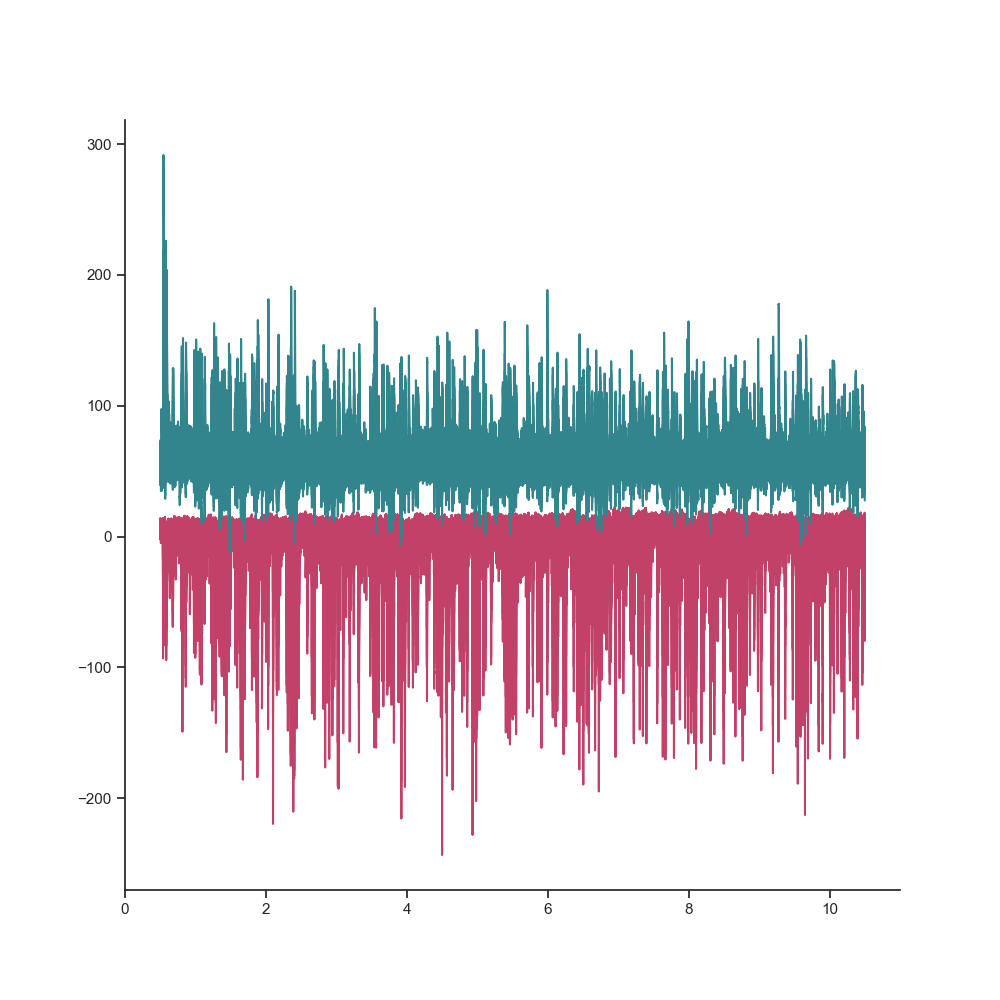

In [20]:
# plot the traces (column 49 to 220049)
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
for idx, row in df.iterrows():
    if row['clampPotential'] == -70:
        ax.plot(np.linspace(0.5,10.5,200000), row[10049:210049], color=flare(0.5))
    else:
        ax.plot(np.linspace(0.5,10.5,200000), 50 + row[10049:210049], color=crest(0.5))

In [29]:
# sactterplot
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
for pat in df['sweep'].unique():
    vecE = df.loc[(df['sweep'] == pat)&(df['clampPotential']==-70)].iloc[0,10049:210049].to_numpy()
    vecI = df.loc[(df['sweep'] == pat)&(df['clampPotential']==0)].iloc[0,10049:210049].to_numpy()
    print(vecI.shape, vecE. shape)
    # ax.plot(-1*vecE, vecI, alpha=0.2)

    # correlation between E and I
    print(pat, np.convolve(vecE, vecI))


In [53]:
# Define your custom function
def _get_synaptic_impact(row):
    idx = row.name
    traceid = str(row['cellID']) + '_' + str(row['exptID']) + '_' + str(row['sweep'])    
    Fs = 2e4
    pps = int(Fs*row['probePulseStart'])
    pts = int(Fs*row['pulseTrainStart'])
    ipi = int(Fs / row['stimFreq'])
    numPulses = row['numPulses']
    t0 = 49 + pts
    t1 = 49 + pts + (numPulses)*ipi
    trace = row.iloc[t0:t1]
    
    if row['clampPotential'] == -70:
        trace = -trace

    trace = trace - np.min(trace)
    
    synaptic_charge = np.trapz(trace) / Fs # nA.ms

    sr = synaptic_charge * row['stimFreq'] # unit = nA.ms / s

    results = fp.fit(trace)

    if si>1000:
        print(f"for index:{idx}, traceID:{traceid}, freq:{row['stimFreq']} Hz the Synaptic impact = {si:.2f} nA.ms / s")

    return si,sr

In [54]:
for idx,row in dfslice.iterrows():
    dfslice.loc[idx, ['synaptic_impact','synaptic_reserve'] = _get_synaptic_impact(row )
# remove columns 49:80049 from the df and create a new variable
dfshort = pd.concat([dfslice.iloc[:, :49], dfslice.iloc[:, 80049:]], axis=1)

for index:97, traceID:1931_6_2, freq:50 Hz the Synaptic impact = 3596.94 nA.ms / s
for index:98, traceID:1931_6_3, freq:50 Hz the Synaptic impact = 3379.65 nA.ms / s
for index:100, traceID:1931_6_5, freq:50 Hz the Synaptic impact = 3440.71 nA.ms / s
for index:101, traceID:1931_6_6, freq:50 Hz the Synaptic impact = 3538.78 nA.ms / s
for index:104, traceID:1931_6_9, freq:50 Hz the Synaptic impact = 3019.78 nA.ms / s
for index:106, traceID:1931_6_11, freq:50 Hz the Synaptic impact = 2805.12 nA.ms / s
for index:107, traceID:1931_6_12, freq:50 Hz the Synaptic impact = 2804.16 nA.ms / s
for index:108, traceID:1931_6_13, freq:50 Hz the Synaptic impact = 2900.00 nA.ms / s
for index:110, traceID:1931_6_15, freq:50 Hz the Synaptic impact = 2826.51 nA.ms / s
for index:112, traceID:1931_6_17, freq:50 Hz the Synaptic impact = 2503.70 nA.ms / s
for index:113, traceID:1931_6_18, freq:50 Hz the Synaptic impact = 2593.99 nA.ms / s
for index:115, traceID:1931_6_20, freq:50 Hz the Synaptic impact = 2398.

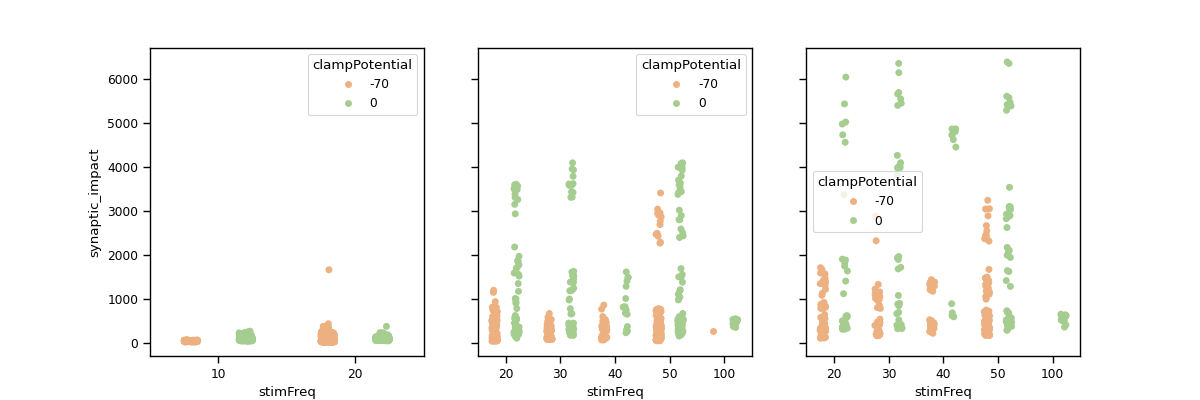

In [56]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
for s,sq in enumerate([1,5,15]):
    sns.stripplot(data=dfshort[dfshort['numSq']==sq], x='stimFreq', y='synaptic_impact', hue='clampPotential', dodge=True, palette=color_EI, ax=ax[s])

In [47]:
def _get_synaptic_reserve(row):
    idx = row.name
    traceid = str(row['cellID']) + '_' + str(row['exptID']) + '_' + str(row['sweep'])    
    Fs = 2e4
    pps = int(Fs*row['probePulseStart'])
    pts = int(Fs*row['pulseTrainStart'])
    ipi = int(Fs / row['stimFreq'])
    numPulses = row['numPulses']
    t0 = 49 + pts
    t1 = 49 + pts + (numPulses)*ipi
    trace = row.iloc[t0:t1]
    
    if row['clampPotential'] == -70:
        trace = -trace

    minimum_point = np.argmin(trace)

10049 10449
[263]
10449 10849
[236]
10849 11249
[188]
11249 11649
[244]
11649 12049
[246]
12049 12449
[224]
12449 12849
[189]
12849 13249
[205]
13249 13649
[]


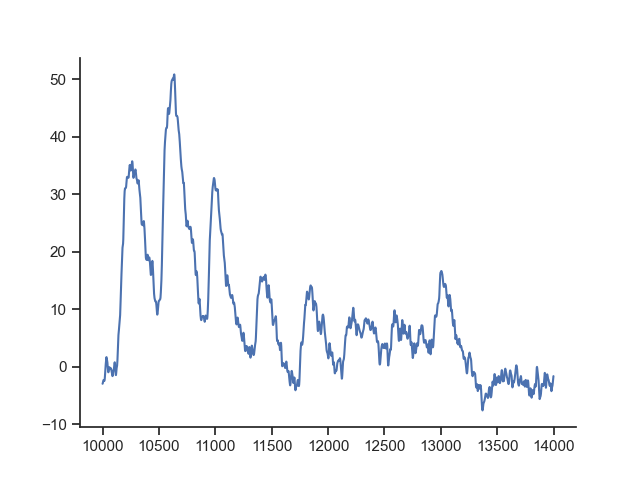

In [18]:
for i in range(10049,13640,400):
    print(i, i+400)
    locs, pocs = find_peaks(-dfslice.loc[568,:][i:i+400], prominence=5)
    print(locs)
plt.figure()
plt.plot( -dfslice.loc[568,:][10049:14049])